<h1> AutoReg</h1>

<h2>Xt = C + ϕ1 Xt-1 + ϕ2 Xt-2 + ϵt</h2>
<h3>An autoregressive (AR) model, often denoted as AR(p), is a statistical time series model used for modeling and forecasting time series data. It's a type of linear regression model that relates a current observation in a time series to past observations. Specifically, an AR(p) model uses the past p observations (lags) of the time series to predict the current value.

1. “t” represents today and we have weekly values, then “t-1” represents last week. Hence, Xt-1 depicts the value recorded a week ago
2. "c" is the constant term
3. "ϕ" the autoregressive coefficients that determine the relationship between the current value and the past p values.
4. "ϵt" is a white noise error term assumed to be normally distributed with mean zero and constant variance.

In [93]:
from pymongo import MongoClient
import pandas as pd

In [94]:
client = MongoClient(host='localhost', port=27017)
db = client['Indian_Cities_Air_Quality']
dar = db['collection']

/kaggle/input/india-city-air-quality-index/India_city_polution_data.json

In [127]:
sites = dar.distinct("id")

In [96]:
sites

['Andhra_Pradesh',
 'Arunachal_Pradesh',
 'Assam',
 'Bihar',
 'Chandigarh',
 'Chhattisgarh',
 'Delhi',
 'Gujarat',
 'Haryana',
 'Jammu_&_Kashmir',
 'Jharkhand',
 'Karnataka',
 'Kerala',
 'Madhya Pradesh',
 'Maharashtra',
 'Meghalaya',
 'Mizoram',
 'Nagaland',
 'Odisha',
 'Puducherry',
 'Punjab',
 'Rajasthan',
 'TamilNadu',
 'Telangana',
 'Tripura',
 'Uttar_Pradesh',
 'West_Bengal']

In [97]:
result = dar.aggregate(
[
    {"$unwind":"$City"},
    {"$unwind":"$City.Station.Pollutant_Index"},
    {
        "$project": {
            "_id":0,
            "State":"$id",
            "City": "$City.id",
            "Pollutant": "$City.Station.Pollutant_Index.id",
            "Avg": "$City.Station.Pollutant_Index.Avg",
            "Max": "$City.Station.Pollutant_Index.Max",
            "Min": "$City.Station.Pollutant_Index.Min",
            "Date": {
                "$dateFromString": {
                    "dateString": "$City.Station.lastupdate",
                    "format": "%d-%m-%Y %H:%M:%S"
                }
            }
        }
    }
]
)

In [98]:
df = pd.DataFrame(list(result))

In [99]:
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] = df['Date'] + pd.to_timedelta(df.index, unit='h')

In [100]:
df.head()

,State,City,Pollutant,Avg,Max,Min,Date
0,Andhra_Pradesh,Amaravati,PM2.5,30,70,10,2021-12-07 10:00:00
1,Andhra_Pradesh,Amaravati,PM10,43,88,12,2021-12-07 11:00:00
2,Andhra_Pradesh,Amaravati,NO2,19,33,7,2021-12-07 12:00:00
3,Andhra_Pradesh,Amaravati,NH3,3,4,2,2021-12-07 13:00:00
4,Andhra_Pradesh,Amaravati,SO2,29,108,13,2021-12-07 14:00:00


In [101]:
print(df.shape)
print(df.info())

(829, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 829 entries, 0 to 828
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   State      829 non-null    object        
 1   City       829 non-null    object        
 2   Pollutant  829 non-null    object        
 3   Avg        829 non-null    object        
 4   Max        829 non-null    object        
 5   Min        829 non-null    object        
 6   Date       829 non-null    datetime64[ns]
dtypes: datetime64[ns](1), object(6)
memory usage: 45.5+ KB
None


In [102]:
ts = df[df["Pollutant"]=="PM2.5"]

In [103]:
ts.head()

,State,City,Pollutant,Avg,Max,Min,Date
0,Andhra_Pradesh,Amaravati,PM2.5,30,70,10,2021-12-07 10:00:00
7,Andhra_Pradesh,Rajamahendravaram,PM2.5,35,88,15,2021-12-07 17:00:00
14,Andhra_Pradesh,Tirupati,PM2.5,122,179,60,2021-12-08 00:00:00
21,Andhra_Pradesh,Visakhapatnam,PM2.5,39,75,21,2021-12-08 07:00:00
28,Arunachal_Pradesh,Naharlagun,PM2.5,NA,NA,NA,2021-12-08 14:00:00


In [104]:
ts2 = ts[["Date", "Max"]]
ts2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122 entries, 0 to 822
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    122 non-null    datetime64[ns]
 1   Max     122 non-null    object        
dtypes: datetime64[ns](1), object(1)
memory usage: 2.9+ KB


In [105]:
ts2 = ts2[ts2['Max'] != 'NA']
ts2['Max'] = ts2["Max"].astype('float32')

In [106]:
ts2.set_index('Date')

,Max
Date,
2021-12-07 10:00:00,70.0
2021-12-07 17:00:00,88.0
2021-12-08 00:00:00,179.0
2021-12-08 07:00:00,75.0
2021-12-09 03:00:00,320.0
...,...
2022-01-09 07:00:00,344.0
2022-01-09 14:00:00,322.0
2022-01-09 21:00:00,118.0


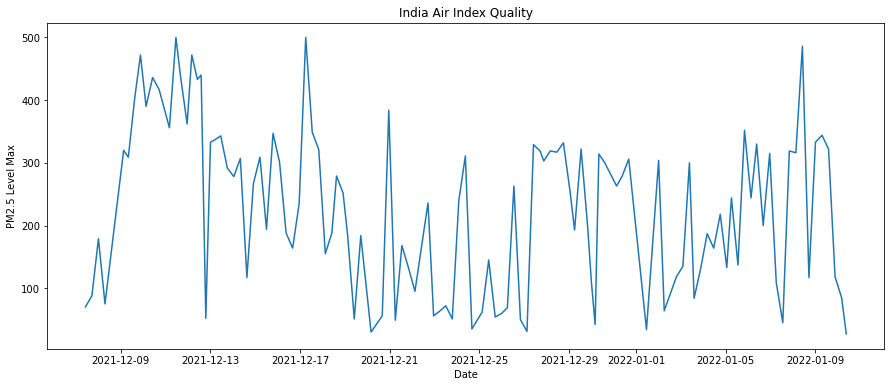

In [107]:
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

plt.figure(figsize=(15,6))
plt.plot(ts2['Date'], ts2['Max'])
plt.xlabel("Date")
plt.ylabel("PM2.5 Level Max") 
plt.title("India Air Index Quality");

In [108]:
from statsmodels.tsa.ar_model import AutoReg
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

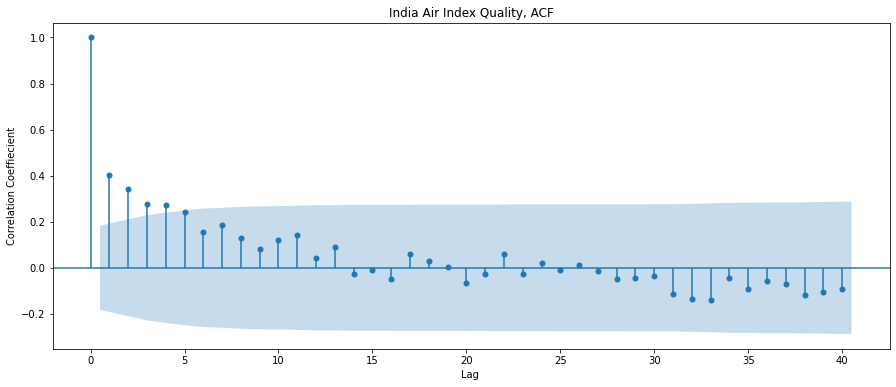

In [109]:
fig, ax = plt.subplots(figsize=(15,6))
plot_acf(ts2['Max'],lags=40, ax=ax)
plt.xlabel("Lag ")
plt.ylabel("Correlation Coeffiecient") 
plt.title("India Air Index Quality, ACF");

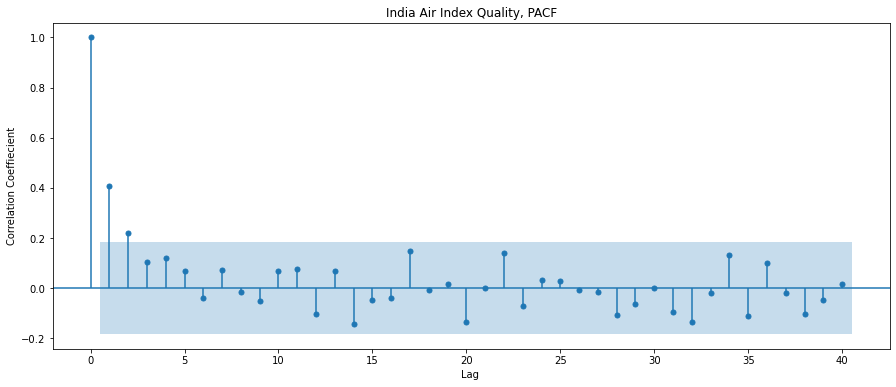

In [110]:
fig, ax = plt.subplots(figsize=(15,6))
plot_pacf(ts2['Max'],lags=40, ax=ax)
plt.xlabel("Lag ")
plt.ylabel("Correlation Coeffiecient") 
plt.title("India Air Index Quality, PACF");

In [111]:
# split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(ts2["Max"], ts2["Date"], test_size=0.2, random_state=42)

In [112]:
print("X_train:",X_train.shape)
print("X_test:",X_test.shape)
print("y_train:",y_train.shape)
print("y_test:",y_test.shape)

X_train: (92,)
X_test: (23,)
y_train: (92,)
y_test: (23,)


In [113]:
# Baseline

X_train_mean = X_train.mean()
X_pred_baseline = [X_train_mean] * len(X_train)
mae_baseline = mean_absolute_error(X_train, X_pred_baseline)

print("Mean PM2.5 Max reading", X_train_mean)
print("Baseline MAE: ", mae_baseline)

Mean PM2.5 Max reading 229.81521606445312
Baseline MAE:  110.25803408415422


In [114]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np

p_params  = range(1, 31)
maes = []
for p in p_params:
    model = AutoReg(X_train, lags=p).fit()
    
    y_pred = model.predict(start=p, end=len(X_train)-1)
    
    y_pred = y_pred[~np.isnan(y_pred)]
    
    X_trimmed = X_train.iloc[p:p+len(y_pred)]
    
    mae=mean_absolute_error(X_trimmed, y_pred)
    maes.append(mae)
    
mae_series = pd.Series(maes, name='mae', index=p_params)
mae_series.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
C:\ProgramData\Anaconda3\lib\site-packages\statsmode

1    133.791835
2    138.432545
3    139.247555
4    143.253109
5    140.159895
Name: mae, dtype: float64

In [115]:
mae_series.sort_values(ascending=False)[:5]

22    198.936365
24    191.386194
21    165.948055
29    148.689744
4     143.253109
Name: mae, dtype: float64

In [125]:
best_p = 5

best_model = AutoReg(X_train, lags=best_p).fit()

X_train_resid = best_model.resid
X_train_resid.name = 'residuals'
X_train_resid.head()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


306   NaN
775   NaN
546   NaN
114   NaN
208   NaN
Name: residuals, dtype: float64

<AxesSubplot:>

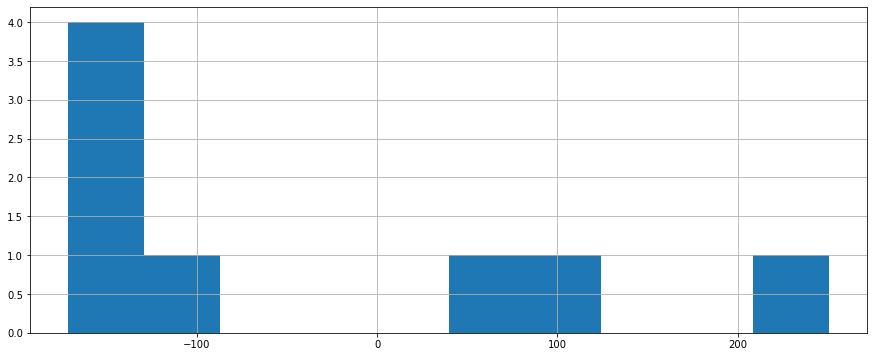

In [126]:
fig, ax =plt.subplots(figsize=(15,6))
X_train_resid.hist()


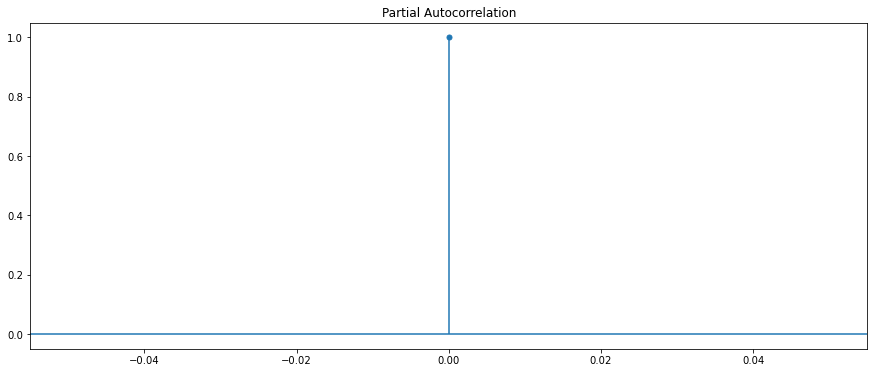

In [130]:
fig, ax =plt.subplots(figsize=(15,6))
plot_pacf(X_train_resid, ax=ax);

In [ ]:
# Evaluate

y_pred_wfv = pd.Series()
history = X_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=5).fit()
    next_pred = model.forecast()
    y_pred_wfv = y_pred_wfv.append(next_pred)
    history = history.append(y_test[next_pred.index])
    
y_pred_wfv.name = "prediction"
y_pred_wfv.index.name = "timestamp"
y_pred_wfv.head()